In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from urllib.parse import urlparse
import html
import unicodedata
import json
import os
import chromadb
from sentence_transformers import SentenceTransformer
import time
import csv
from tqdm import tqdm
import plotly.express as px


#### Raw Data
Source: UTM parking website: https://www.utm.utoronto.ca/parking 

In [3]:
# Attempt to retrieve the UTM parking webpage
try:
    # Send a GET request to the target URL
    response = requests.get("https://www.utm.utoronto.ca/parking")
    
    # Raise an exception if the response contains an HTTP error status code
    response.raise_for_status()

except requests.exceptions.SSLError as e:
    # Handle SSL certificate verification errors
    # Possible actions: log the error, notify the user, retry with a different CA bundle, or fail gracefully
    print("SSL verification failed:", e)

In [4]:
# Check if the HTTP request to the UTM parking page was successful
if response.status_code == 200:
    # Parse the HTML content of the page using BeautifulSoup
    soup = BeautifulSoup(response.content, "html.parser")

    # Extract the base domain to help construct absolute URLs from relative paths
    parsed_url = urlparse("https://www.utm.utoronto.ca/parking/")
    base_url = f"{parsed_url.scheme}://{parsed_url.netloc}"

    # Find all anchor tags with href attributes
    links = soup.find_all("a", href=True)

    # Initialize a set to track unique URLs and a list to store extracted link data
    seen_urls = set()
    extracted_links = []

    # Iterate through all found links
    for link in links:
        href = link["href"]

        # Filter for links related to the parking section of the UTM site
        if "utm.utoronto.ca/parking" in href or href.startswith("/parking"):
            # Convert relative URLs to absolute URLs
            full_url = href if href.startswith("http") else f"https://www.utm.utoronto.ca{href}"

            # Ensure the link belongs to the same domain
            if parsed_url.netloc in urlparse(full_url).netloc:
                # Avoid duplicates by checking if the URL has already been seen
                if full_url not in seen_urls:
                    seen_urls.add(full_url)
                    # Extract the visible text of the link
                    text = link.get_text(strip=True)
                    # Store the topic and URL in the results list
                    extracted_links.append({"Topic": text, "URL": full_url})

    # Convert the list of extracted links into a DataFrame for further processing
    urls = pd.DataFrame(extracted_links)
    print("URLs extracted and saved successfully")

else:
    # Log an error if the initial request failed
    print(f"Error: Failed to retrieve URLs. Status code: {response.status_code}")

URLs extracted and saved successfully


In [5]:
# Initialize a list to store cleaned and relevant content extracted from each webpage
data = []

def normalize_unescape(text: str) -> str:
    """
    Normalize and clean scraped text by:
    - Unescaping HTML entities
    - Normalizing Unicode characters
    - Replacing common punctuation artifacts
    - Removing excessive punctuation and whitespace
    """
    if not isinstance(text, str):
        return ""

    # Decode HTML entities and normalize Unicode characters
    text = html.unescape(text)
    text = unicodedata.normalize("NFKC", text)

    # Replace common scraping artifacts and smart punctuation
    replacements = {
        "\\(": "(", "\\)": ")", "\\-": "-", "\\/": "/", "\\&amp;amp;": "&amp;amp;",
        "’": "'", "“": '"', "”": '"', "–": "-", "—": "-"
    }
    for old, new in replacements.items():
        text = text.replace(old, new)

    # Normalize excessive punctuation and whitespace
    text = re.sub(r"\.{4,}", "...", text)         # Replace 4+ dots with ellipsis
    text = re.sub(r"([!?])\1+", r"\1", text)       # Collapse repeated ! or ?
    text = re.sub(r"-{2,}", "-", text)             # Collapse repeated dashes
    text = text.replace("\xa0", " ").replace("\u200b", "")  # Remove non-breaking and zero-width spaces
    text = re.sub(r"[ \t]+", " ", text)            # Collapse multiple spaces/tabs
    text = re.sub(r"\n{3,}", "\n\n", text)         # Limit consecutive newlines

    return text.strip()

# Compile a regex pattern to identify boilerplate or non-informative text
BOILERPLATE_RE = re.compile(
    r"\b(Back to the top|Shortcuts|Questions\s+Contact us|Contact us|Making experiences exceptional)\b",
    flags=re.IGNORECASE
)

def is_boilerplate(line: str) -> bool:
    """
    Determine if a line of text is boilerplate or too short to be meaningful.
    Returns True if the line should be excluded.
    """
    return not line or len(line.split()) < 2 or BOILERPLATE_RE.search(line)

# Iterate through each URL and topic in the DataFrame to scrape content
for _, row in urls.iterrows():
    url, topic = row["URL"], row["Topic"]

    try:
        # Send a GET request to the URL
        response = requests.get(url)
        response.raise_for_status()

        # Parse the HTML content of the page
        soup = BeautifulSoup(response.text, "html.parser")

        # Extract and clean text from header and paragraph tags
        for tag in soup.find_all(["h1", "h2", "h3", "h4", "p"]):
            text = normalize_unescape(tag.get_text(strip=True, separator=" "))

            # Skip boilerplate, empty, or irrelevant content
            if (
                not text or
                is_boilerplate(text) or
                text.startswith(("We wish to acknowledge this land", "Statement of Land Acknowledgement"))
            ):
                continue

            # Append cleaned content to the data list
            data.append({"URL": url, "Topic": topic, "Content": text})

    except Exception as e:
        # Log any errors encountered during the scraping process
        print(f"Failed to scrape {topic} ({url}): {e}")

In [6]:
# convert extracted data to a dataframe 
df = pd.DataFrame(data)

#group data by URL and topic
grouped_df = df.groupby(["URL", "Topic"])["Content"].apply(lambda texts:" ".join(texts)).reset_index()
grouped_df.head()

,URL,Topic,Content
0,https://www.utm.utoronto.ca/parking/,Parking,"We oversee all things parking on campus, and a..."
1,https://www.utm.utoronto.ca/parking/AMPparkApp,Download our App,"Parking Payment Options on Campus The ""AMP Par..."
2,https://www.utm.utoronto.ca/parking/barrier-fr...,Barrier Free Parking,Barrier Free Parking UTM Parking & Transportat...
3,https://www.utm.utoronto.ca/parking/car-care-c...,UTM Car Care Center,"Car Care Center In a rush, unexpected spill, o..."
4,https://www.utm.utoronto.ca/parking/contact-us,Contact Us,Office Hours 8:30am-11am 12:30pm-3:30pm Our of...


In [7]:
# Save the grouped data to a CSV file
grouped_df.to_csv("../data/utm_parking_data.csv", index=False)

In [8]:
# Open the CSV file for further processing
with open("../data/utm_parking_data.csv", "r", encoding="utf-8") as file:
    parking_data = csv.DictReader(file)
    # Convert the CSV data into a dataframe
    grouped_df = pd.DataFrame(parking_data)  

grouped_df.head()  

,URL,Topic,Content
0,https://www.utm.utoronto.ca/parking/,Parking,"We oversee all things parking on campus, and a..."
1,https://www.utm.utoronto.ca/parking/AMPparkApp,Download our App,"Parking Payment Options on Campus The ""AMP Par..."
2,https://www.utm.utoronto.ca/parking/barrier-fr...,Barrier Free Parking,Barrier Free Parking UTM Parking & Transportat...
3,https://www.utm.utoronto.ca/parking/car-care-c...,UTM Car Care Center,"Car Care Center In a rush, unexpected spill, o..."
4,https://www.utm.utoronto.ca/parking/contact-us,Contact Us,Office Hours 8:30am-11am 12:30pm-3:30pm Our of...


#### Vector Database
ChromaDB: https://github.com/chroma-core/chroma

In [9]:
# Ensure os is available in this kernel (import if not already imported)
if os not in globals():
	import os
# Set custom persistence directory
os.environ["CHROMA_DB_DIR"] = "../chroma_storage"

# Ensure chromadb is available in this kernel (import if not already imported)
if "chromadb" not in globals():
	import chromadb

# Initialize ChromaDB client and create a new collection for BGE-Large embeddings
chroma_client = chromadb.Client()
collection_name = "faq_parking_data"
collection = chroma_client.get_or_create_collection(name=collection_name)

#### Data Processing

In [10]:
# Load embedding model
embed_model = SentenceTransformer("BAAI/bge-large-en-v1.5")

In [11]:
# Text normalization and filtering utilities for preprocessing scraped content

def clean_text(text):
    """
    Normalize a string by:
    - Unescaping HTML entities
    - Collapsing multiple whitespace characters into a single space
    - Stripping leading/trailing whitespace
    """
    text = html.unescape(text)                     # Convert HTML entities to readable characters
    text = re.sub(r'\s+', ' ', text)               # Replace multiple whitespace with a single space
    return text.strip()                            # Remove leading/trailing whitespace


def is_chunk_clean(chunk):
    """
    Determine whether a text chunk is clean and relevant by checking for known noise patterns.
    
    Returns False if any predefined noise keyword is found in the chunk (case-insensitive).
    """
    noise_keywords = [
        "back to top", "learn more", "purchase totals", "cancellation or refunds",
        "included in rates below", "subject to a", "may differ slightly", "parking on campus"
    ]
    # Return True only if none of the noise keywords are present in the chunk
    return not any(kw in chunk.lower() for kw in noise_keywords)

In [12]:
# Splits a given text into individual sentences using punctuation marks (., !, ?) followed by whitespace.
# This helps in isolating logical sentence boundaries for further processing.
def split_into_sentences(text):
    return re.split(r'(?<=[.!?])\s+', str(text).strip())

# Further splits a sentence into sub-phrases using common delimiters such as semicolons, commas, colons, and hyphens.
# Useful for breaking down complex sentences into smaller, manageable parts.
def sub_chunk_sentence(sentence):
    return re.split(r'[;,:-]', sentence)

# Splits a long text into overlapping chunks based on a maximum token count.
# Each chunk contains up to `max_tokens` words, with `overlap` words shared between consecutive chunks.
# This is particularly useful for models with input size limitations, such as transformer-based NLP models.
def chunk_with_overlap(text, max_tokens=128, overlap=32):
    words = text.split()
    chunks = []
    start = 0
    while start < len(words):
        end = min(start + max_tokens, len(words))
        chunk = ' '.join(words[start:end])
        chunks.append(chunk)
        start += max_tokens - overlap  # Move start forward, keeping overlap with previous chunk
    return chunks

In [13]:
# Generates embeddings for a given text using overlap-aware chunking.
# 1. The input text is first split into overlapping chunks using `chunk_with_overlap`, which helps preserve context across chunk boundaries.
# 2. Each chunk is then passed to the embedding model (`embed_model`) to generate vector representations.
# 3. The function returns a list of tuples, where each tuple contains the original chunk and its corresponding embedding.
def get_embeddings(text):
    chunks = chunk_with_overlap(text)
    embeddings = embed_model.encode(chunks, convert_to_numpy=True)
    return list(zip(chunks, embeddings))

In [14]:
# Ingest cleaned web-scraped parking data into a ChromaDB collection for semantic search or retrieval.
# 
# Parameters:
# - dataframe: A pandas DataFrame containing web content with columns "Content" and "URL".
# - collection: A ChromaDB collection object where processed chunks and embeddings will be stored.
#
# Workflow:
# 1. Iterates through each row of the DataFrame.
# 2. Cleans the content and splits it into sentences, then further into sub-chunks.
# 3. Filters out empty or noisy chunks using `is_chunk_clean`.
# 4. Generates embeddings for each clean chunk using `get_embeddings`.
# 5. Deduplicates chunks using a `seen_chunks` set to avoid redundant storage.
# 6. Constructs metadata and unique IDs for each chunk.
# 7. Adds the processed chunks, metadata, embeddings, and IDs to the ChromaDB collection.
# 8. Prints the total number of embedded chunks for logging and verification.

def ingest_parking_data(dataframe, collection):
    seen_chunks = set()
    total_chunks = 0

    for i, row in dataframe.iterrows():
        content = clean_text(row["Content"])
        url = row["URL"]

        sentences = split_into_sentences(content)
        documents, metadatas, embeddings, ids = [], [], [], []

        for j, sentence in enumerate(sentences):
            sub_chunks = sub_chunk_sentence(sentence)
            for k, chunk in enumerate(sub_chunks):
                chunk = clean_text(chunk)
                if not chunk or not is_chunk_clean(chunk):
                    continue
                chunk_embeds = get_embeddings(chunk)
                for m, (chunk_text, embedding) in enumerate(chunk_embeds):
                    chunk_text = clean_text(chunk_text)
                    if chunk_text in seen_chunks:
                        continue
                    seen_chunks.add(chunk_text)
                    chunk_id = f"chunk_{i}_{j}_{k}_{m}"
                    documents.append(chunk_text)
                    metadatas.append({"url": url})
                    embeddings.append(embedding)
                    ids.append(chunk_id)

        if documents:
            collection.add(
                documents=documents,
                metadatas=metadatas,
                embeddings=embeddings,
                ids=ids
            )
            total_chunks += len(documents)

    print(f"Embedded {total_chunks} chunks from parking web data into ChromaDB.")

In [15]:
# Ingests parking rate information from a plain text file into a ChromaDB collection.
#
# Parameters:
# - file_path: Path to the .txt file containing parking rate information.
# - collection: A ChromaDB collection object where the processed text chunks and their embeddings will be stored.
#
# Workflow:
# 1. Reads and decodes the raw text from the file, unescaping HTML entities and normalizing whitespace.
# 2. Defines a local `chunk_with_overlap` function to split the text into overlapping chunks, ensuring context preservation across chunk boundaries.
# 3. Iterates over each chunk:
#    - Generates an embedding using `embed_model`.
#    - Assigns a unique ID to each chunk.
#    - Attaches metadata indicating the source file.
# 4. Adds all chunks, embeddings, IDs, and metadata to the ChromaDB collection.
# 5. Logs the total number of embedded chunks for verification.

def ingest_parking_rates_from_txt(file_path, collection):
    with open(file_path, "r", encoding="utf-8") as file:
        raw_text = html.unescape(file.read())
        raw_text = re.sub(r"\s+", " ", raw_text).strip()

    def chunk_with_overlap(text, max_tokens=128, overlap=32):
        words = text.split()
        chunks = []
        start = 0
        while start < len(words):
            end = min(start + max_tokens, len(words))
            chunk = ' '.join(words[start:end])
            chunks.append(chunk)
            start += max_tokens - overlap
        return chunks

    chunks = chunk_with_overlap(raw_text)
    documents, embeddings, ids, metadatas = [], [], [], []

    for i, chunk in enumerate(chunks):
        embedding = embed_model.encode(chunk, convert_to_numpy=True)
        documents.append(chunk)
        embeddings.append(embedding)
        ids.append(f"parking_chunk_{i}")
        metadatas.append({"source": "utm_parking_rates.txt"})

    collection.add(documents=documents, embeddings=embeddings, ids=ids, metadatas=metadatas)
    print(f"Embedded {len(chunks)} chunks from parking rates data into ChromaDB.")

In [16]:
# Ingest parking rates data into ChromaDB
ingest_parking_rates_from_txt("../data/utm_parking_rates.txt", collection)

Embedded 5 chunks from parking rates data into ChromaDB.


In [17]:
# Ingest parking web data into ChromaDB
ingest_parking_data(grouped_df, collection)

Embedded 639 chunks from parking web data into ChromaDB.


### Retrieval-Augmented Generation (RAG)
RAG combines a large language model (in this case, Mistral Instruct: https://ollama.com/library/mistral:instruct) and an information retrieval system (in this case, embeddings stored in ChromaDB)

In [48]:
import dpnp as np
import numpy as onp
from sklearn.metrics.pairwise import cosine_similarity
import subprocess
import dpctl

# Answer user questions using the Mistral model via the Ollama CLI.
#
# Parameters:
# - user_question: The input question string from the user.
# - top_k: Number of top relevant context chunks to retrieve based on semantic similarity (default: 15).
# - ollama_path: Path to the Ollama CLI executable (default: "ollama").
#
# Workflow:
# 1. Access the GPU using dpctl and dpnp for efficient embedding computation.
# 2. Encode the user question into an embedding using `embed_model`.
# 3. Query the ChromaDB collection for the top-k most semantically similar chunks.
# 4. Extract documents, embeddings, and metadata (e.g., URLs) from the query results.
# 5. Compute cosine similarity scores between the question embedding and retrieved embeddings.
# 6. Filter out low-relevance chunks using a similarity threshold.
# 7. Rank the remaining chunks by similarity and construct a context string from the top-ranked ones.
# 8. Truncate the context to a maximum character limit to avoid prompt overflow.
# 9. Build a prompt instructing the Mistral model to answer strictly based on the provided context.
# 10. Run the prompt through the Ollama CLI and capture the model's output.
# 11. Return the model's answer along with the context and raw output.
# 12. If the model fails to answer or returns an empty response, fall back to a default message with a reference URL.
# 13. Handle errors gracefully, including missing CLI or subprocess failures.

# Create SYCL queue for Intel GPU
try:
    q = dpctl.SyclQueue("level_zero:gpu")
    print(f"Active SYCL device: {q.sycl_device.name}")
except dpctl.SyclQueueCreationError:
    raise RuntimeError("Could not create a SYCL queue for the GPU device.")

def answer_question(user_question, top_k=15, ollama_path="ollama"):
    # Embed question on GPU using dpnp
    query_embedding = np.array(embed_model.encode([user_question], convert_to_numpy=True)[0])
    query_embedding_list = query_embedding.asnumpy().tolist()

    # Query ChromaDB for top-k relevant chunks
    results = collection.query(
        query_embeddings=[query_embedding_list],
        n_results=top_k,
        include=["documents", "metadatas", "embeddings"]
    )

    # Convert retrieved embeddings to numpy arrays for similarity computation
    retrieved_embeddings = [np.array(emb).asnumpy() if hasattr(emb, 'asnumpy') else onp.array(emb) for emb in results["embeddings"][0]]

    # Compute cosine similarity (scikit-learn requires numpy arrays)
    similarities = cosine_similarity(query_embedding.asnumpy().reshape(1, -1), retrieved_embeddings)[0]

    # Rank and filter by similarity threshold
    retrieved_sentences = results["documents"][0]
    retrieved_urls = [meta.get("url") for meta in results["metadatas"][0] if meta.get("url")]
    fallback_url = retrieved_urls[0] if retrieved_urls else "https://www.utm.utoronto.ca/parking/"
    fallback_phrase = f"I'm not sure how to answer that. You may want to visit: {fallback_url}"

    ranked_indices = onp.argsort(similarities)[::-1]
    SIMILARITY_THRESHOLD = 0.4
    filtered_indices = [i for i in ranked_indices if similarities[i] >= SIMILARITY_THRESHOLD]
    ranked_sentences = [retrieved_sentences[i] for i in filtered_indices]

    # Limit context size to avoid prompt overflow
    MAX_CONTEXT_CHARS = 3000
    context = "\n".join(ranked_sentences)[:MAX_CONTEXT_CHARS]

    # Build prompt for Ollama
    prompt = f"""You are a knowledgeable assistant helping users with questions about parking at the University of Toronto Mississauga (UTM).

Below is information retrieved from the official UTM parking website. Use this information to answer the user's question. Do not use any external knowledge.

If the answer is not found in the context, respond with:
'{fallback_phrase}'

--- UTM Parking Website Information ---
{context}
---------------------------------------

User Question: {user_question}

Answer:"""

    # Query Mistral model via Ollama CLI
    try:
        result = subprocess.run(
            [ollama_path, "run", "mistral:instruct"],
            input=prompt,
            text=True,
            capture_output=True,
            encoding="utf-8"
        )
        answer = result.stdout.strip()

        if not answer or answer == fallback_phrase:
            return {"answer": fallback_phrase, "context": context, "raw_answer": answer}

        return {"answer": answer, "context": context, "raw_answer": answer}

    except FileNotFoundError:
        return {"answer": "Error: 'ollama' CLI not found.", "context": "", "raw_answer": ""}
    except subprocess.CalledProcessError as e:
        return {"answer": f"Error: {e.stderr}", "context": "", "raw_answer": ""}


Active SYCL device: Intel(R) Arc(TM) 140T GPU (16GB)


### Inference

In [ ]:
# Computation or function call
sample_question = "How much is parking permit?"
generated_answer = answer_question(sample_question)

print("Answer:", generated_answer["answer"])
print("Context:", generated_answer["context"])
print("Raw Answer:", generated_answer["raw_answer"])


Answer: A parking permit at the University of Toronto Mississauga (UTM) varies in cost depending on the type of permit you require. Here are some examples:

- Annual Student Parking Permits range from $74.05 per month for P4 & P8 permits to $1,587.75 annually for a CCT Garage permit.
- Sessional Student Parking Permits cost $93.47 per month during the Fall & Winter terms, or $373.87 for a single term (either Fall, Winter, or Summer). The CCT Garage Sessional permit costs $162.16 per month.
- Evening & Weekend Parking Permits cost $22.00 per month.
- Contractor Parking Permits are $129.04 per month.
- Resident Parking Permits for the 2024 academic year range in cost depending on the location, with P5 lots priced at $84.72 per month and CCT Garage lots priced at $132.31 per month. The P7 lottery-based permits for Schreiberwood families are not currently available, and the P10 lottery-based permits for MacGrath Valley residents are also unavailable.
- Staff & Faculty Annual Parking Permit

In [44]:
# Computation or function call
sample_question = "Is there free parking on campus?"
generated_answer = answer_question(sample_question)

print("Answer:", generated_answer["answer"])
print("Context:", generated_answer["context"])
print("Raw Answer:", generated_answer["raw_answer"])


Answer: No, there is no free parking on campus at the University of Toronto Mississauga (UTM). All parking is paid parking.
Context: there is nowhere on campus that you can park for free.
Do faculty and staff pay for parking?
Parking on the UTM Campus Whether you're coming to campus for the year or just a few hours
Visitor Parking Whether you're on campus for a few hours or coming consistently
To inquire about parking for any other U of T campus
faculty and students may park in any barrier free (accessible) parking space in any lot on campus
More Information regarding parking enforcement on campus
if you park on campus more than once a week
Free Parking UTM Department Vehicles General Parking Information Parking availability is not guaranteed.
Is there somewhere close by I can park?
paid UTM parking.
paid parking.
permit parking
Parking Payment Options on Campus The "AMP Park" app Now you have the choice to pay for parking using our easy
GEORGE CAMPUS PARKING PERMITS St.
Raw Answer: No

#### Testing

In [40]:
# Additional testing.  Generate a json file for a list of questions

test_questions = [
        "What are the daily and hourly parking rates at UTM?",
        "Where can I find a map of all parking lots on campus?",
        "Are there any free parking options available at UTM?",
        "What are the busiest times for parking on campus?",
        "How do I apply for a student parking permit at UTM?",
        "What types of parking permits are available for staff, faculty, and contractors?",
        "Can I register multiple vehicles under one parking permit?",
        "How do I cancel my parking permit and request a refund?",
        "Where are the barrier-free accessible parking spaces located on campus?",
        "Can visitors with accessible needs use the AMP Park app to pay for parking?",
        "How does the AMP Park mobile app work for paying parking fees?",
        "What is License Plate Recognition (LPR) and how does it affect parking enforcement?"
    ]


with open("../data/parking_test_questions.json", "w", encoding="utf-8") as f:
    json.dump(test_questions, f, indent=2)

print("File created: parking_test_questions.json")

File created: parking_test_questions.json


In [41]:
# Load test questions from JSON file
with open("../data/parking_test_questions.json", "r", encoding="utf-8") as f:
    test_questions = json.load(f)

# Initialize results list
test_results = []

try:
    # Create a SYCL queue for GPU
    #q = dpctl.SyclQueue("gpu")  # or "level_zero:gpu" for Intel Arc
    q = dpctl.SyclQueue("level_zero:gpu")  
    print(f"Active device is: {q.sycl_device.name}")

    # Process each question with a progress bar
    for question in tqdm(test_questions, desc="Processing Questions"):
        start_time = time.time()
        try:
            result = answer_question(user_question=question)
            end_time = time.time()
            duration = round(end_time - start_time, 2)

            fallback_detected = "visit:" in result.get("answer", "").lower()

            test_results.append({
                "question": question,
                "answer": result.get("answer"),
                "context": result.get("context"),
                "raw_answer": result.get("raw_answer"),
                "checklist_format": result.get("checklist_format", ""),
                "duration_seconds": duration,
                "fallback_detected": fallback_detected
            })
        except Exception as e:
            end_time = time.time()
            duration = round(end_time - start_time, 2)
            test_results.append({
                "question": question,
                "error": str(e),
                "duration_seconds": duration,
                "fallback_detected": True
            })
except dpctl.SyclQueueCreationError:
    print("Could not create a SYCL queue for the GPU device.")
except Exception as e:
    print(f"An error occurred: {e}")
    
# Save results to JSON
with open("../data/parking_test_results.json", "w", encoding="utf-8") as f:
    json.dump(test_results, f, indent=2)

# Save results to CSV
csv_fields = ["question", "answer", "duration_seconds", "fallback_detected"]
with open("../data/parking_test_results.csv", "w", encoding="utf-8", newline='') as f:
    writer = csv.DictWriter(f, fieldnames=csv_fields)
    writer.writeheader()
    for row in test_results:
        writer.writerow({
            "question": row.get("question"),
            "answer": row.get("answer", row.get("error", "")),
            "duration_seconds": row.get("duration_seconds"),
            "fallback_detected": row.get("fallback_detected")
        })

# Visualization: Fallback Detection Frequency (Pie Chart)
fallback_counts = {
    "Fallback Triggered": sum(1 for r in test_results if r.get("fallback_detected")),
    "Answer Provided": sum(1 for r in test_results if not r.get("fallback_detected"))
}
fig_pie = px.pie(
    names=list(fallback_counts.keys()),
    values=list(fallback_counts.values()),
    title="Fallback Detection Frequency"
)
fig_pie.write_html("../data/fallback_detection_pie.html")
fig_pie.write_json("../data/fallback_detection_pie.json")

# Visualization: Average Response Time per Question (Bar Chart)
questions = [r["question"] for r in test_results]
durations = [r["duration_seconds"] for r in test_results]
fig_bar = px.bar(
    x=questions,
    y=durations,
    labels={"x": "Question", "y": "Response Time (s)"},
    title="Response Time per Question"
)
fig_bar.update_layout(xaxis_tickangle=-45)
fig_bar.write_html("../data/response_time_bar.html")
fig_bar.write_json("../data/response_time_bar.json")

print("Test results saved to parking_test_results.json and parking_test_results.csv")
print("Charts saved to fallback_detection_pie.html and response_time_bar.html")

Active device is: Intel(R) Arc(TM) 140T GPU (16GB)


Processing Questions: 100%|██████████| 12/12 [05:58<00:00, 29.89s/it]


Test results saved to parking_test_results.json and parking_test_results.csv
Charts saved to fallback_detection_pie.html and response_time_bar.html


### Flask-based Web Interface

In [ ]:
from flask import Flask, render_template, request, jsonify
import threading

# Get the absolute path to the top-level project directory
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Create Flask app with updated template and static folder paths
app = Flask(
    __name__,
    template_folder=os.path.join(BASE_DIR, 'templates'),
    static_folder=os.path.join(BASE_DIR, 'static')
)

In [46]:
# Set base directory to the parent of the current working directory
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Create Flask app with correct template/static paths
app = Flask(
    __name__,
    template_folder=os.path.join(BASE_DIR, 'templates'),
    static_folder=os.path.join(BASE_DIR, 'static')
)

@app.route("/")
def index():
    return render_template("chat.html")

@app.route("/ask", methods=["POST"])
def ask():
    user_question = request.json.get("question")
    start_time = time.time()
    result = answer_question(user_question)  # Ensure this function is defined in the notebook
    duration = round(time.time() - start_time, 2)

    return jsonify({
        "question": user_question,
        "answer": result["answer"],
        "context": result["context"],
        "duration": duration,
        "fallback": "visit:" in result["answer"].lower()
    })

In [47]:
# Function to run Flask app in a separate thread
def run_flask():
    app.run(debug=True, use_reloader=False)

# Start Flask app in a background thread
thread = threading.Thread(target=run_flask)
thread.start()

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [01/Dec/2025 14:10:06] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Dec/2025 14:10:06] "GET /static/uoft_theme.css HTTP/1.1" 304 -
127.0.0.1 - - [01/Dec/2025 14:10:06] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [01/Dec/2025 14:11:47] "POST /ask HTTP/1.1" 200 -


#### Sample Output from Flask API

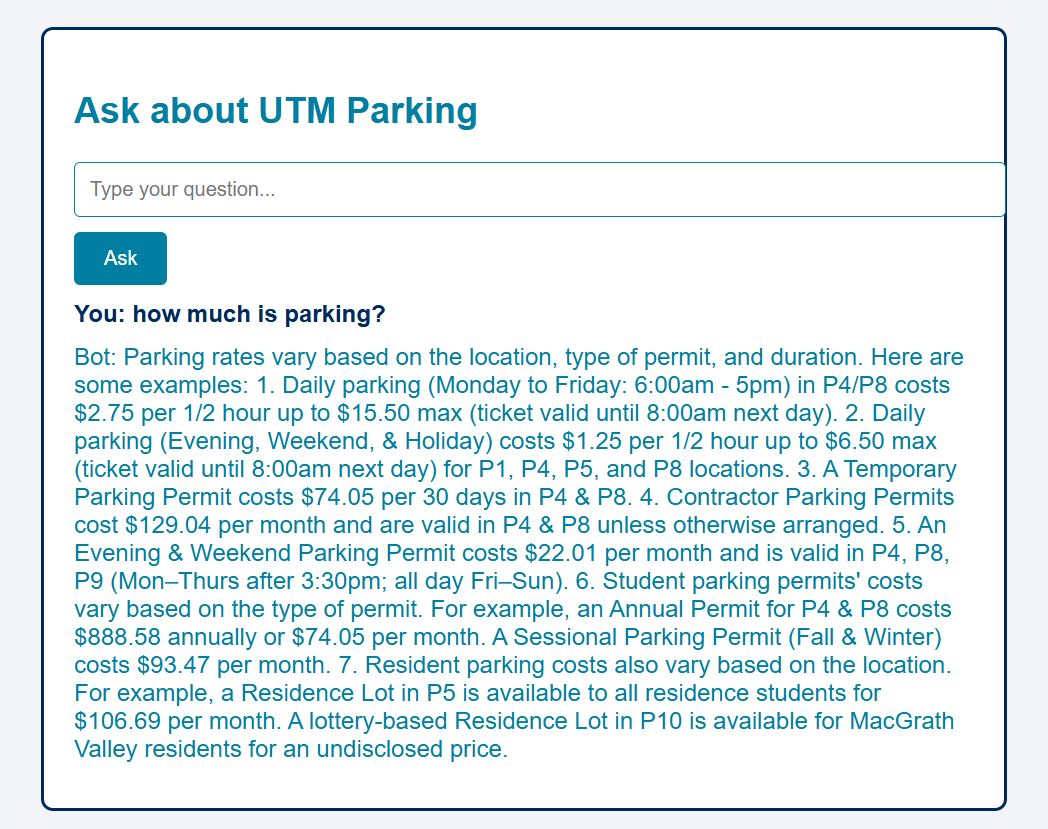